## Анализ программы лояльности магазина строительных материалов</div>


</b> В нашем распоряжении маркетинговые данные программы лояльности магазина строительных материалов «Строили, строили и наконец построили», представляющей из себя применение различных скидок, специальных предложений, подарков посредством использования персональных карт. Наша задача состоит в оценке результатов внедрения программы и составления рекомендаций по дальнейшему её использованию. Для этого поставим сформулируем цель исследования и определим основные этапы, которые помогут понять насколько оказалось эффективным применение программы и представить рекомендации для отдела маркетинга.</div>


 #### Задачи исследования</div>


1. Провести исследовательский анализ данных для определения основных показателей клиентов, показывающих эффективность применения программы лояльности.</div>
2. Осуществить маркетинговое исследование, позволяющее получить основные ритейл-метрики для когортного анализа клиентов участвующих в программе и не участвующих в ней.</div>
3. Оценить эффективность применения программы лояльности и определить целесообразность её дальнейшего использования.</div>


#### Ход исследования</div>


</b> Маркетинговые данные мы получим из файлов `/datasets/product_codes.csv`, `/datasets/retail_dataset.csv`, состоящих из данных о продаваемом товаре, данных о покупках и покупателях. О качестве исходных данных ничего неизвестно, поэтому прежде, чем приступать непосредственно к исследованию, необходимо провести обзор данных на предмет наличия возможных ошибок и постараться исправить эти ошибки для исключения их влияния на дальнейшее исследование и возможность искажения полученных данных.</div>
</b> Таким образом, наше исследование будет состоять из следующих этапов:</div>


- Обзор и предобработка данных</div>
- Расчет временного интервала, определение профиля пользователя</div>
- Исследовательский анализ данных и визуальное отражение количества пользователей и доли участвующих в программе лояльности и  не участвующих и занести результаты в отдельную таблицу</div>
- Проведение анализа эффективности программы лояльности, включающее в себя:
   - расчет среднего количества товара в разбивке по когортам;
   - расчет общей суммы денег, которую один клиент в разных когортах в среднем приносит магазину со всех своих покупок (LTV);
   - расчет среднего чека покупателей в разбивке по когортам.</div>
- Проверка статистических гипотез:
   - средний чек участников программы лояльности выше, чем у остальных покупателей;
   - среднее количество товара в корзине покупателей, участвующих в программе, больше, чем у остальных.</div>
- Подведение итогов исследования и формулировка рекомендаций для отдела маркетинга</div>

 ### Обзор и предобработка данных</div>

Изучим данные и выполним предобработку. Посмотрим есть ли в данных пропуски и дубликаты. Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратим внимание на столбцы с датой и временем. Также посмотрим на названия колонок и при необходимости изменим их.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt #загрузим необходимые библиотеки

In [2]:
data, product_data = (
    pd.read_csv('D:/обучение/Аналитик данных/projects/final_project/final/retail_dataset.csv', sep=','),
    pd.read_csv('D:/обучение/Аналитик данных/projects/final_project/final/product_codes.csv')
               )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [4]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


Необходимо изменить типы данных в колонках purchase_date (привести к формату datetime), customer_id (привести к формату object) и loyalty_program (привести к формату bool).

In [5]:
data.isna().sum() #проверим, имеются ли пропуски в данных

purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36210
ShopID                 0
loyalty_program        0
dtype: int64

In [6]:
product_data.isna().sum()

productID        0
price_per_one    0
dtype: int64

В колонке customer_id присутствуют значения NaN. Скорее всего это пользователи, не участвующие в программе лояльности. Поставим заглушку вместо отсутствующих значений и поменяем типы колонок.

In [7]:
data.columns = data.columns.str.lower()
product_data.columns = product_data.columns.str.lower()
data.rename(columns={
    'purchaseid':'purchase_id',
    'purchasedate':'purchase_date',
    'customerid':'customer_id',
    'shopid':'shop_id'
    }, inplace = True)
data['loyalty_program'] = data['loyalty_program'].astype('bool')
data['customer_id'] = data['customer_id'].fillna(0)
data['customer_id'] = data['customer_id'].astype('int')
data['purchase_date'] = pd.to_datetime(data['purchase_date'])
product_data.rename(columns={
    'productid':'item_id'}, inplace = True) #приведем названия колонок к нижнему регистру и добавим нижний разделитель

In [8]:
data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,True
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,True
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,True
...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,0,Shop 0,False
105331,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,False
105332,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,True
105333,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,False


In [9]:
data.duplicated().sum() #проверим таблицу data на присутствие дубликатов

1033

In [10]:
data = data.drop_duplicates()

In [11]:
product_data.duplicated(subset='item_id').sum() 
# также проверим в колонке с id товаров таблицы product_data наличие дубликатов

6810

В датасете data нашлось 1033 строки с дублирующимися данными, что составляет менее 1%. Удалим эти строки для исключения возможных искажений в будущих исследованиях.
В датасете product_data также есть дубликаты в колонке item_id. Вероятно дублирующиеся id товаров появились из-за того, что цены на один и тот же товар менялись в процессе продаж (разные закупочные цены, скидки, снижение цен на стоковый товар и тому подобное). Скорее всего было бы корректным не удалять дубликаты, так как мы не знаем наиболее актуальную цену, а присвоить таким товарам медианное значение.

In [12]:
product_data = product_data.groupby(by='item_id', as_index=False).agg({'price_per_one':'median'})

Определим временной интервал представленных данных.

In [13]:
data['purchase_date'].max()

Timestamp('2017-02-28 17:04:00')

In [14]:
data['purchase_date'].min()

Timestamp('2016-12-01 08:26:00')

<b>В процессе предобработки представленных данных мы привели названия колонок в таблицах к единообразию, преобразовали данные в некоторых столбцах и удалили дубликаты. В результате предварительного анализа мы выяснили, что будем исследовать данные о покупательской активности за период с 01 декабря 2016 года по 28 февраля 2017 года. После удаления дублирующихся значений в таблице data имеется 104302 строки с данными об id покупателей, магазинов, стоимости и количестве купленного товара товара, дате покупок и участии или неучастии покупателя в программе лояльности.<b>

 ### Исследовательский анализ данных</div>

На данном этапе нашей работы мы выясним, сколько покупателей принимает участие в программе лояльности и сколько остается вне программы и таким образом определим когорты для дальнейшего анализа, рассчитаем коэффициент удержания клиента, "жизненную ценность" клиента, а также средний чек в разбивке по когортам.

,loyalty_program,customer_id
0,False,1163
1,True,587


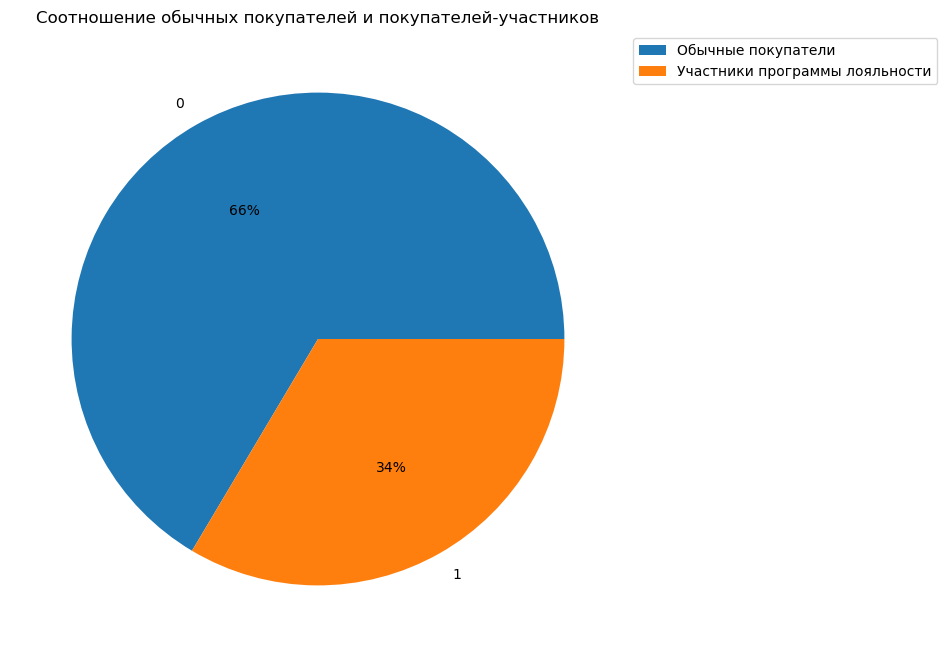

In [15]:
data_loyalty = (data.groupby('loyalty_program', as_index=False).agg({'customer_id': 'nunique'}))
display(data_loyalty)
data_loyalty.plot(y='customer_id', kind='pie', autopct='%1.0f%%', subplots=True, figsize=(8, 8))
plt.title('Соотношение обычных покупателей и покупателей-участников')
plt.ylabel('')
plt.legend(['Обычные покупатели', 'Участники программы лояльности'], bbox_to_anchor=( 1 , 1 ), loc='upper left')
plt.show()

Среди всего количества покупателей только 23412 клиентов принимают участие в программе лояльности, что составляет 34% от общего количества.

Далее рассчитаем сумму каждого чека, для чего сначала посмотрим, какие цены есть в таблице product_data.

In [16]:
product_data.sort_values(by='price_per_one', ascending=True).head()

,item_id,price_per_one
2251,84247C,0.0
2283,84455,0.0
2562,84977,0.0
1875,35644,0.0
2689,85110,0.0


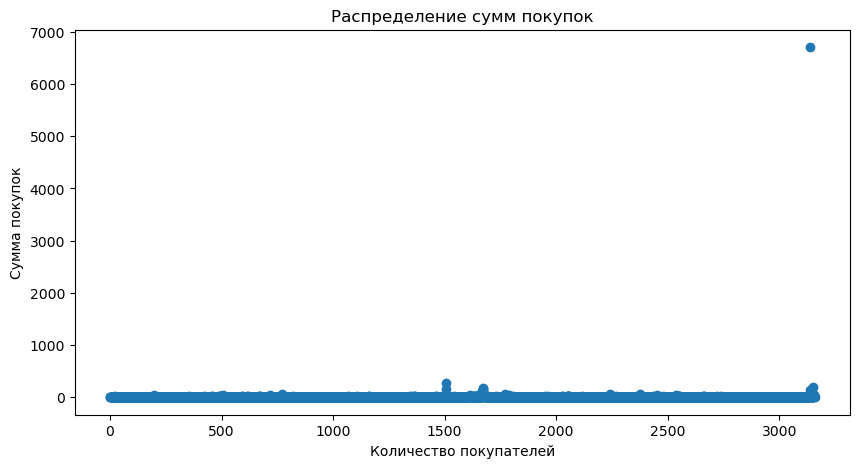

In [17]:
x_values = pd.Series(range(0, len(product_data['price_per_one'])))

fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(x_values, product_data['price_per_one'])
plt.xlabel('Количество покупателей')
plt.ylabel('Сумма покупок')
plt.title('Распределение сумм покупок');

Мы видим, что в таблице присутствует товар с нулевыми ценами, а также есть довольно серьезный выброс. Скорее всего при расчете суммы чека данные выбросы себя проявят, тогда и отсечем их.

In [18]:
data_raw = data.merge(product_data[['item_id', 'price_per_one']], on='item_id', how='left')
data_raw['sum'] = data_raw['quantity']*data_raw['price_per_one']
data_sum = data_raw.groupby('purchase_id', as_index=False).agg({'sum': 'sum'})
data_sum.sort_values(by='sum', ascending=True).head()

,purchase_id,sum
4535,C541433,-77184.640
4101,C536757,-35150.555
4862,C544589,-13413.420
4861,C544587,-13413.420
4423,C540118,-13413.420


Среди покупок есть чеки с отрицательной суммой. В некоторых из таких чеков присутствует товар с обозначением AMAZONFEE, что может означать связанные с маркетплейсом Amazon плату за сбор и упаковку заказов, их доставку и обработку, а также возврат товаров. Еще мы видим, что с колонке с количеством проданного товара есть большие отрицательные значения. Возможными причинами являются ошибочные покупки, возврат товара, а также ошибки при формировании таблицы. Выяснить истинные причины таких отрицательных значений вряд ли удастся, поэтому удалим строки с нулевыми и отрицательными значениями из датасета. 

In [19]:
data_raw

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False,1.630,17.93
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,True,3.290,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,1.630,11.41
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,True,4.370,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,True,5.750,0.00
...,...,...,...,...,...,...,...,...,...
104297,538566,21826,1,2016-12-13 11:21:00,0,Shop 0,False,2.460,2.46
104298,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,False,9.335,0.00
104299,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,True,8.330,8.33
104300,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,False,0.830,9.13


In [20]:
data_raw_s = data_raw.loc[
    (data_raw['quantity'] > 0)&
    (data_raw['price_per_one'] >0)]
data_raw_s.sort_values(by='sum', ascending=True).head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum
78673,538524,17038,1,2016-12-13 09:35:00,0,Shop 0,False,0.100,0.100
82062,537237,84270,1,2016-12-06 09:58:00,0,Shop 0,False,0.105,0.105
28267,543273,47420,1,2017-02-06 11:29:00,22135,Shop 0,True,0.190,0.190
68739,541516,35607A,1,2017-01-18 17:34:00,0,Shop 0,False,0.190,0.190
10739,537792,47420,1,2016-12-08 12:56:00,22064,Shop 0,True,0.190,0.190


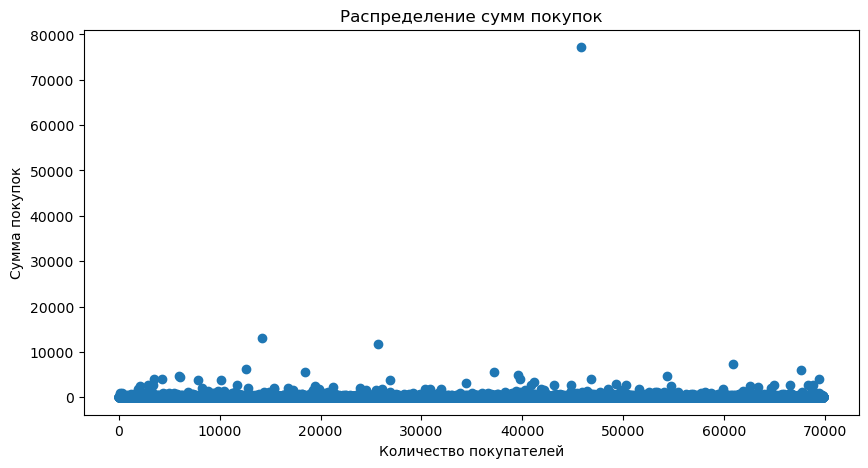

In [21]:
data_raw_s.sort_values(by='sum', ascending=False)

x_values = pd.Series(range(0, len(data_raw_s['sum'])))

fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(x_values, data_raw_s['sum'])
plt.xlabel('Количество покупателей')
plt.ylabel('Сумма покупок')
plt.title('Распределение сумм покупок');

На представленной диаграмме видно, что в покупках наблюдаются выбросы. Посчитаем границы аномальных сумм покупок с помощью расчета 95-й и 99-й перцентилей значения суммы чека и исключим данные покупки. 

In [22]:
np.percentile(data_raw_s['sum'], [95, 99])

array([116.09 , 354.341])

Имеется не более 5% строк на сумму до 116,09р, позиции с суммой более 354,34р наблюдается менее, чем в 1% случаев. Отсеем строки с суммой более 1000р.

In [23]:
data_raw_srt = data_raw_s.loc[data_raw_s['sum'] < 1000]

In [24]:
result_raw_lt = pd.merge(data_raw_srt, data_sum, on=[
    'purchase_id'], how="left", indicator=True).rename(columns={
    'sum_y':'sum_total', 'sum_x':'sum'}).drop(['_merge'], axis=1) #создадим в таблице result_raw_lt колонку с общей суммой чека
result_raw_lt.sort_values(by='sum_total', ascending=False).head().head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum,sum_total
54645,541220,22961,287,2017-01-14 14:11:00,19835,Shop 6,False,2.370,680.190,26374.58
68477,541220,22968,63,2017-01-14 14:11:00,19835,Shop 6,False,14.955,942.165,26374.58
60183,541220,20728,99,2017-01-14 14:11:00,19835,Shop 6,False,4.130,408.870,26374.58
67769,541220,22628,159,2017-01-14 14:11:00,19835,Shop 6,False,4.950,787.050,26374.58
16623,541220,22931,143,2017-01-14 14:11:00,19835,Shop 6,False,2.550,364.650,26374.58


Добавим еще в таблицу колонки с месяцем и днем продажи.

In [25]:
result_raw_lt['month'] = pd.DatetimeIndex(result_raw_lt['purchase_date']).month
result_raw_lt['day'] = pd.DatetimeIndex(result_raw_lt['purchase_date']).day_name()

In [26]:
result_raw_lts = pd.merge(data_raw_s, data_sum, on=[
    'purchase_id'], how="left", indicator=True).rename(columns={
    'sum_y':'sum_total', 'sum_x':'sum'}).drop(['_merge'], axis=1) #создадим такую же таблицу без удаления выбросов

Расчитаем среднее количество товара, которое приобретают покупатели из разных когорт.

,loyalty_program,purchase_id,quantity,mean
0,False,2565,58877,22.95
1,True,1109,27675,24.95


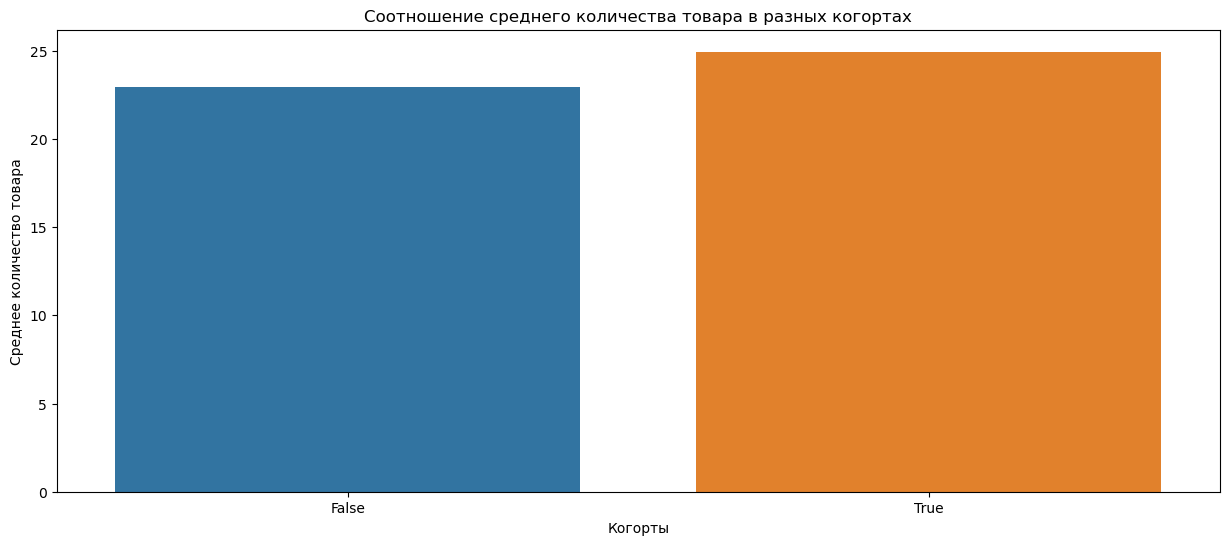

In [27]:
aver_amount = result_raw_lt.drop_duplicates (subset=[
    'purchase_id']).groupby('loyalty_program', as_index=False).agg({'purchase_id':'nunique', 'quantity':'sum'})
aver_amount['mean'] = round((aver_amount['quantity']/aver_amount['purchase_id']),2)
display(aver_amount)

plt.figure(figsize=(15,6))
ax = sns.barplot(data=aver_amount, x="loyalty_program", y="mean")
ax.set(xlabel='Когорты', ylabel='Среднее количество товара', title='Соотношение среднего количества товара в разных когортах');

Данная диаграмма показывает, что в среднем один покупатель, участвующий в программе лояльности, приобретает немного больше товара.

Следующим шагом расчитаем средний чек двух групп, посмотрим какое есть различие в этом показателе.

,loyalty_program,purchase_id,sum_total,mean
0,False,2565,1659549.690,647.00
1,True,1109,545450.725,491.84


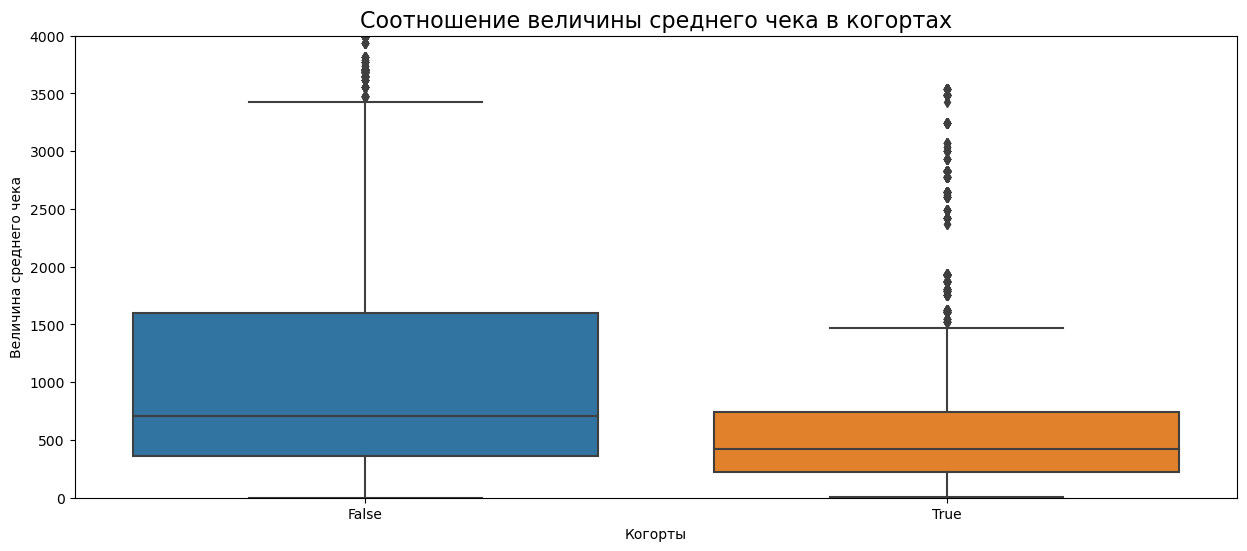

In [28]:
aver_check = result_raw_lt.drop_duplicates (subset=[
    'purchase_id']).groupby('loyalty_program', as_index=False).agg({'purchase_id':'nunique', 'sum_total':'sum'})
aver_check['mean'] = round((aver_check['sum_total']/aver_check['purchase_id']),2)
display(aver_check)

plt.figure(figsize = (15, 6))
boxplot = sns.boxplot(data = result_raw_lt, y='sum_total', x='loyalty_program');
plt.ylim(0, 4000)
boxplot.set_title('Соотношение величины среднего чека в когортах', fontsize=16)
plt.ylabel('Величина среднего чека')
plt.xlabel('Когорты')
plt.show()

Добавим в нашу таблицу колонки с 

In [29]:
result_raw_lt.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum,sum_total,month,day
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False,1.630,17.930,1130.465,12,Saturday
1,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,1.630,11.410,606.185,12,Wednesday
2,541424,79321,1,2017-01-17 17:57:00,0,Shop 0,False,5.750,5.750,1384.870,1,Tuesday
3,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,True,5.205,26.025,305.315,12,Thursday
4,541696,22197,4,2017-01-20 18:08:00,0,Shop 0,False,1.240,4.960,1315.210,1,Friday


В представленных данных есть столбец с id магазина, в котором совершались покупки. Из этого можно сделать вывод, что мы рассматриваем данные продаж сети строительных магазинов. Посмотрим как распределились магазины количеству проданного товара. 

In [30]:
purchase_sort = result_raw_lt.groupby('shop_id', as_index=False).agg({'loyalty_program':'unique', 'quantity':'sum'})
purchase_sorted = purchase_sort.sort_values(by='quantity', ascending=False)
purchase_sorted

,shop_id,loyalty_program,quantity
0,Shop 0,"[False, True]",639039
23,Shop 3,[False],40921
25,Shop 4,[False],18579
27,Shop 6,[False],18368
1,Shop 1,[False],17440
12,Shop 2,[False],13649
11,Shop 19,"[False, True]",6990
6,Shop 14,[False],5455
28,Shop 7,[False],4504
29,Shop 8,"[False, True]",4311


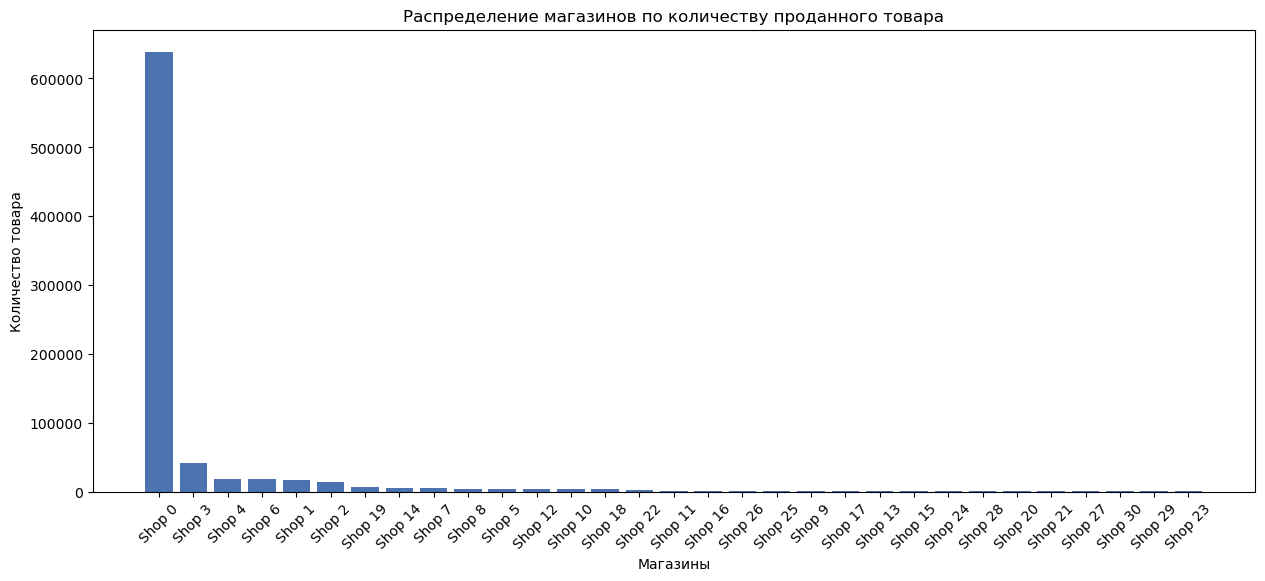

In [31]:
with plt.style.context('seaborn-deep'):
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation=45)
    plt.ylabel('Количество товара')
    plt.xlabel('Магазины')
    plt.title('Распределение магазинов по количеству проданного товара')
    plt.bar(purchase_sorted['shop_id'], purchase_sorted['quantity'])

На этой диаграмме мы видим, что в сети насчитывается 31 магазин. Хотя, если посмотреть на количество проданного товара в магазинах, занимающих последние 12 строк, то возникает сомнение в том, что это отдельно расположенный магазин, так как за три наблюдаемых месяца там было продано менее тысячи единиц товара, а в последних двух магазинах было продано менее 100 единиц. Следует посмотреть на общие суммы проданного товара в этих магазинах.

In [32]:
purchase_sort_sum = result_raw_lt.groupby('shop_id', as_index=False).agg({'loyalty_program':'unique', 'sum_total':'sum'})
purchase_sort_sum = purchase_sort_sum.sort_values(by='sum_total', ascending=False)
purchase_sort_sum

,shop_id,loyalty_program,sum_total
0,Shop 0,"[False, True]",6.424145e+07
23,Shop 3,[False],6.429049e+06
27,Shop 6,[False],2.109677e+06
12,Shop 2,[False],2.108788e+06
25,Shop 4,[False],1.939560e+06
1,Shop 1,[False],1.600265e+06
6,Shop 14,[False],7.572828e+05
28,Shop 7,[False],7.123231e+05
29,Shop 8,"[False, True]",5.961890e+05
26,Shop 5,[False],4.108302e+05


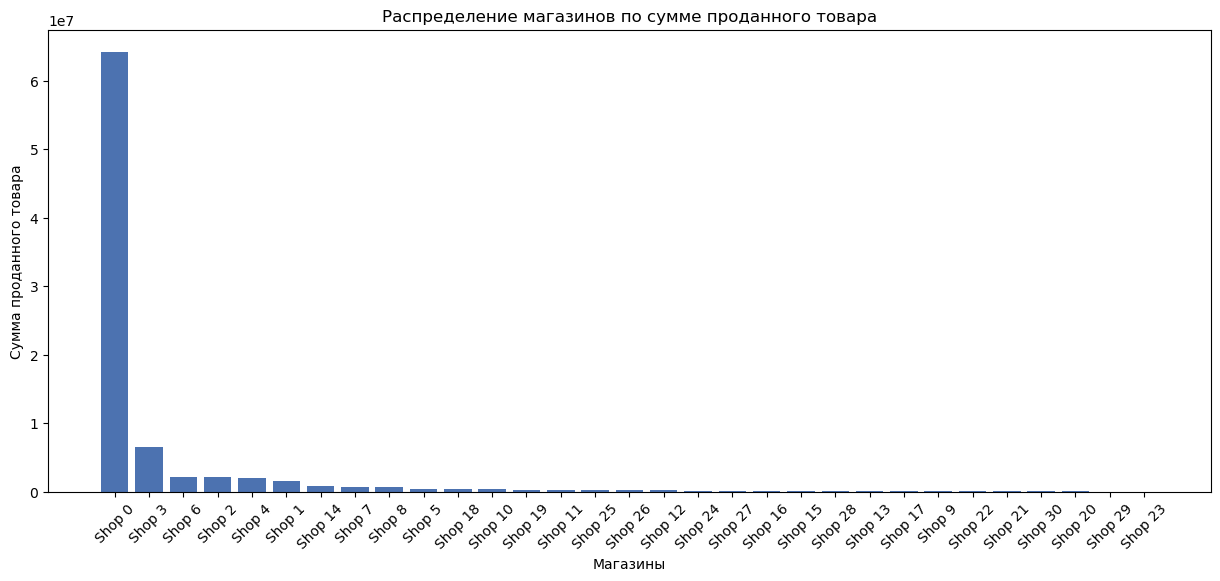

In [33]:
with plt.style.context('seaborn-deep'):
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation=45)
    plt.ylabel('Сумма проданного товара')
    plt.xlabel('Магазины')
    plt.title('Распределение магазинов по сумме проданного товара')
    plt.bar(purchase_sort_sum['shop_id'], purchase_sort_sum['sum_total'])

По нашему мнению, это не отдельно расположенные помещения магазинов, а одни из каналов сбыта, возможно интернет каналы, либо обозначение какого-либо внутреннего перемещения товара. В любом случае, эти магазины имеют довольно низкие показатели, чтобы повлиять на общий анализ. Основным каналом сбыта является shop 0, затем с очень серьезным отставанием (более 90%) идет shop 3, потом расположились shop 6, shop 2, shop 4 и shop 1 с примерно одинаковыми показателями. 

Если смотреть на покупки участников программы лояльности, то из полученных данных видно, что в данной программе участвуют только 4 магазина: Shop 0, Shop 8, Shop 19, Shop 28. Причем в первых двух покупки совершают и участники программы и обычные покупатели, в shop 28 только участники. Возможно данную программу решили протестировать только в нескольких магазинах для получения аналитических данных об экономической целесообразности её внедрения во все магазины. Поэтому вероятно наш дальнейший анализ надо провести, ориентируясь на эти магазины, а также добавить в этот список Shop 15, так как там показатели "продажи количества единиц товара" и "общая сумма продажи" примерно схожи с Shop 28.

In [38]:
rr = result_raw_lt.loc[
    (result_raw_lt['shop_id'] == 'Shop 0')|
    (result_raw_lt['shop_id'] == 'Shop 8')
]
rr

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum,sum_total,month,day
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False,1.630,17.930,1130.465,12,Saturday
1,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,1.630,11.410,606.185,12,Wednesday
2,541424,79321,1,2017-01-17 17:57:00,0,Shop 0,False,5.750,5.750,1384.870,1,Tuesday
3,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,True,5.205,26.025,305.315,12,Thursday
4,541696,22197,4,2017-01-20 18:08:00,0,Shop 0,False,1.240,4.960,1315.210,1,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
69737,540154,22134,3,2017-01-05 11:30:00,0,Shop 0,False,0.630,1.890,952.835,1,Thursday
69738,538566,21826,1,2016-12-13 11:21:00,0,Shop 0,False,2.460,2.460,1758.970,12,Tuesday
69739,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,True,8.330,8.330,427.790,12,Friday
69740,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,False,0.830,9.130,176.250,12,Saturday


Так как условием участия в программе лояльности является ежемесячная оплата 200 рублей, то нам необходимо добавить эти 200 рублей к сумме одной из покупок, произведенной в каждом месяце.

In [39]:
rr = result_raw_sort.drop_duplicates (subset=[
    'customer_id', 'month']).query('loyalty_program == True').drop(['shop_id',
                                                                    'price_per_one',
                                                                    'month',
                                                                    'day',
                                                                    'quantity',
                                                                    'item_id',
                                                                    'sum'], axis=1)
rr['sum_total'] = rr['sum_total']+200
data_sort = pd.merge(
    result_raw_sort, rr, on=[
        'customer_id'], how="left", indicator=True).rename(columns={
    'purchase_id_x':'purchase_id',
    'purchase_date_x':'purchase_date',
    'sum_total_x':'sum_total',
    'loyalty_program_x':'loyalty_program',}).drop(['purchase_id_y',
                                                   'purchase_date_y',
                                                   'loyalty_program_y',
                                                   '_merge'], axis=1)
data_sort['sum_total_y'] = data_sort['sum_total_y'].fillna(data_sort['sum_total'])
data_sort.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum,sum_total,month,day,sum_total_y
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,False,1.630,17.930,1130.465,12,Saturday,1130.465
1,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,1.630,11.410,606.185,12,Wednesday,806.185
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,True,1.630,11.410,606.185,12,Wednesday,531.985
3,541424,79321,1,2017-01-17 17:57:00,0,Shop 0,False,5.750,5.750,1384.870,1,Tuesday,1384.870
4,537795,82494L,5,2016-12-08 13:03:00,22892,Shop 0,True,5.205,26.025,305.315,12,Thursday,505.315


Посмотрим, изменились ли данные о величине среднего чека после сортировки таблицы по магазинам.

,loyalty_program,purchase_id,sum,mean
0,False,2263,1195383.025,647.00
1,True,1109,959864.555,491.84


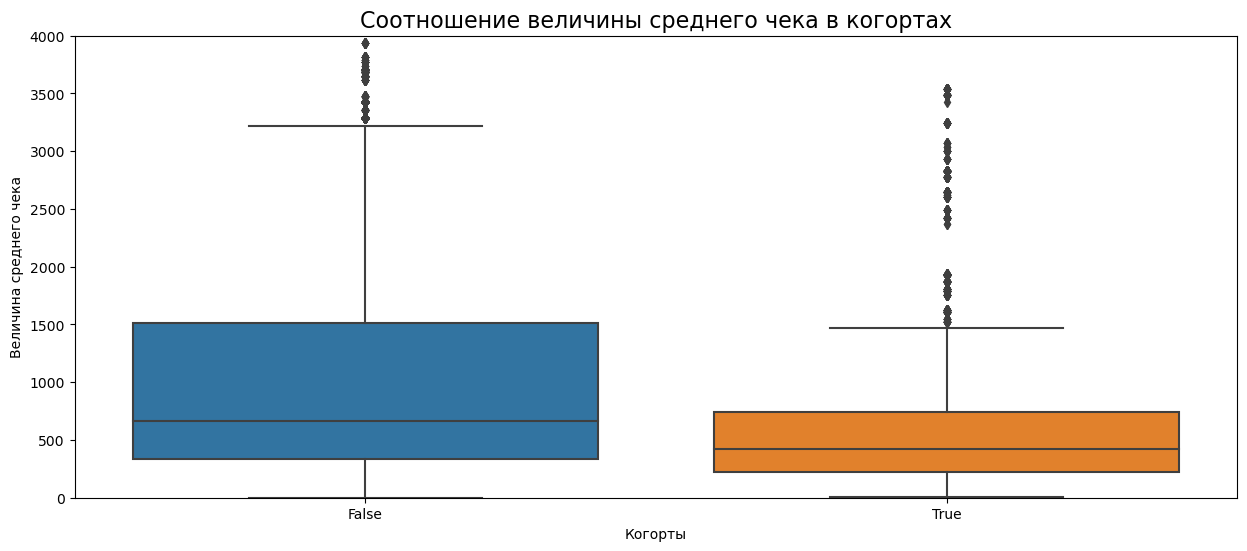

In [40]:
aver_check_sort = data_sort.groupby('loyalty_program', as_index=False).agg({'purchase_id':'nunique', 'sum':'sum'})
aver_check_sort['mean'] = round((aver_check['sum_total']/aver_check['purchase_id']),2)
display(aver_check_sort)

plt.figure(figsize = (15, 6))
boxplot = sns.boxplot(data = result_raw_sort, y='sum_total', x='loyalty_program');
plt.ylim(0, 4000)
boxplot.set_title('Соотношение величины среднего чека в когортах', fontsize=16)
plt.ylabel('Величина среднего чека')
plt.xlabel('Когорты')
plt.show()

Показатели среднего чека остались практически с теми же значениями.

Проанализируем, в какие дни покупатели из разных когорт предпочитают совершать больше покупок и каков размер этих покупок.

In [41]:
data_sort.sort_values(by='customer_id', ascending=False).head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,sum,sum_total,month,day,sum_total_y
57177,541854,21870,5,2017-01-23 14:58:00,23962,Shop 0,True,2.27,11.35,39.16,1,Monday,212.52
7107,540350,85099B,1,2017-01-06 14:14:00,23962,Shop 0,True,1.95,1.95,12.52,1,Friday,212.52
64417,545079,21717,1,2017-02-28 10:30:00,23962,Shop 0,True,2.55,2.55,53.25,2,Tuesday,212.52
44338,545079,22754,1,2017-02-28 10:30:00,23962,Shop 0,True,0.85,0.85,53.25,2,Tuesday,253.25
44339,545079,22754,1,2017-02-28 10:30:00,23962,Shop 0,True,0.85,0.85,53.25,2,Tuesday,212.52


In [42]:
quantity_day = data_sort.groupby([
    'day', 'loyalty_program'],
    as_index=False).agg({'purchase_id':'count'}).sort_values(by=['purchase_id', 'loyalty_program'], ascending=False)
quantity_day

,day,loyalty_program,purchase_id
0,Friday,False,8953
8,Tuesday,False,8945
10,Wednesday,False,8144
6,Thursday,False,8020
4,Saturday,False,7932
1,Friday,True,5890
7,Thursday,True,5741
11,Wednesday,True,5018
9,Tuesday,True,4968
3,Monday,True,4900


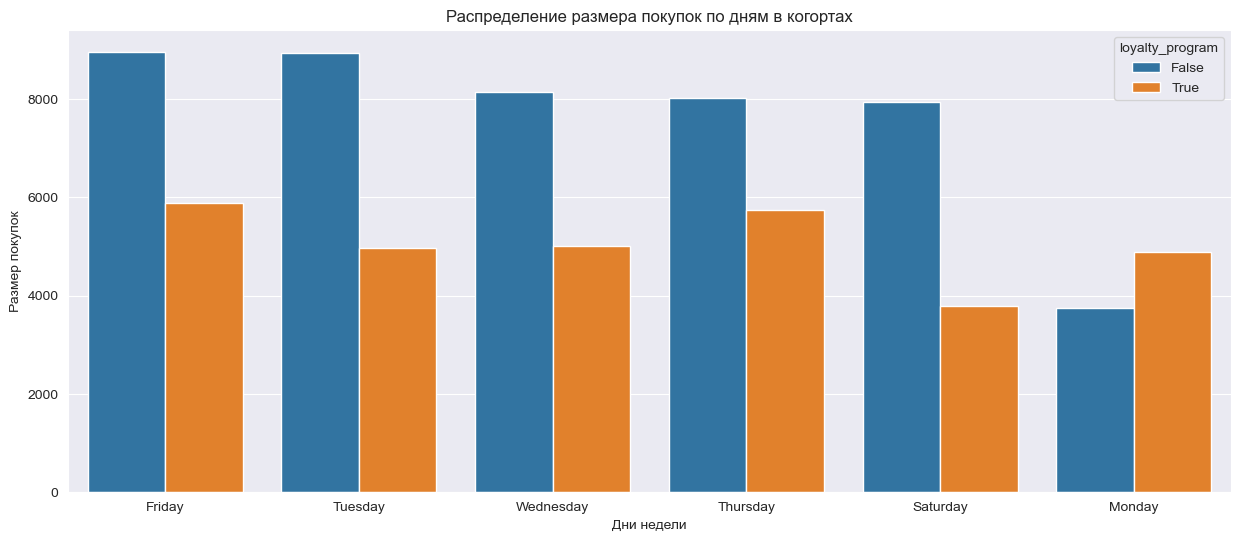

In [43]:
plt.figure(figsize=(15, 6))
sns.set_style('darkgrid')
sns.barplot(x='day', y='purchase_id', hue='loyalty_program', data=quantity_day)
plt.title('Распределение размера покупок по дням в когортах')
plt.ylabel('Размер покупок')
plt.xlabel('Дни недели')
plt.show()

По диаграмме видно, что покупатели из разных когорт любят закупаться по пятницам, в остальные дни показатели размера покупок отличаются у двух групп. У обычных покупателей популярные дни после пятницы вторник, среда, четверг и суббота. В понедельник обычные посетители магазина делают самые маленькие по размеру покупки.
У участников программы наблюдается немного другая картина. После пятницы следующий день четверг, затем вторник, среда, понедельник и суббота.

По какой-то причине в данных отсутствует информация о продажах по воскресеньям.  Посмотрим присутствует ли воскресенье в исходном датасете.

In [44]:
data['day'] = data['purchase_date'].dt.weekday
data['day'].unique()

C:\Users\centu\AppData\Local\Temp\ipykernel_18016\792597383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['purchase_date'].dt.weekday


array([5, 2, 3, 0, 1, 4], dtype=int64)

Все верно, в данных по какой-то причине нет информации о воскресных продажах. Предположим, что в воскресенье в сети магазинов выходной день.

 Также посмотрим, как распределяются закупки по месяцам.

In [45]:
quantity_month = data_sort.groupby([
    'month', 'loyalty_program'],
    as_index=False).agg({'purchase_id':'count'}).sort_values(by=['purchase_id', 'loyalty_program'], ascending=False)
quantity_month

,month,loyalty_program,purchase_id
4,12,False,17905
0,1,False,16158
5,12,True,11833
2,2,False,11685
3,2,True,9405
1,1,True,9078


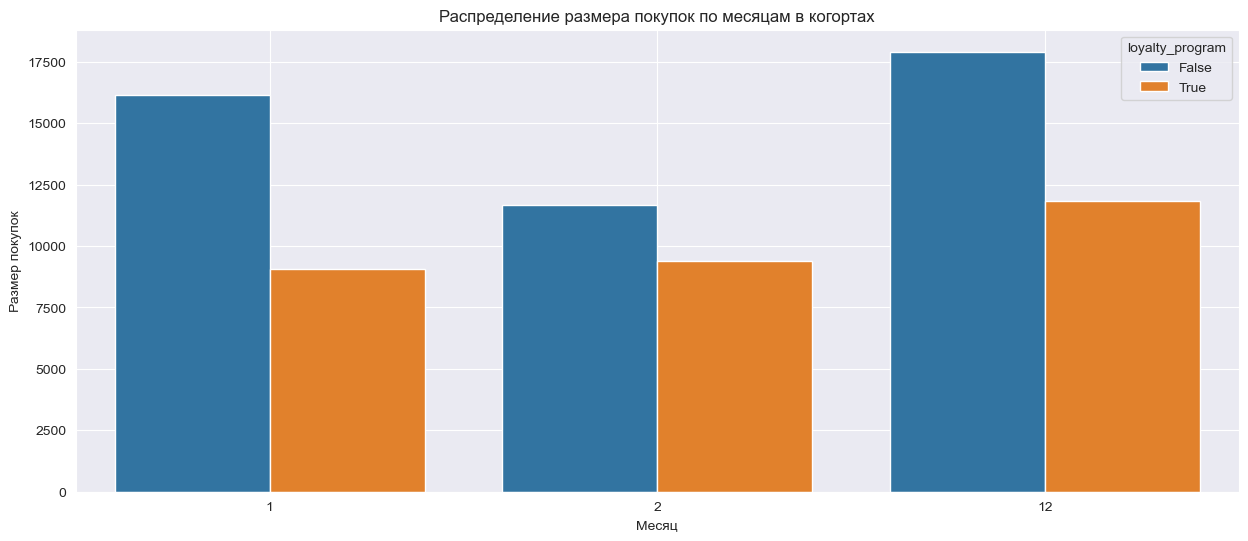

In [46]:
sns.set_style('dark')
plt.figure(figsize=(15, 6))
sns.barplot(x='month', y='purchase_id', data=quantity_month, hue='loyalty_program')
plt.title('Распределение размера покупок по месяцам в когортах')
plt.xlabel('Месяц')
plt.ylabel('Размер покупок')
#plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Большее количество товара покупалось в декабре, затем в когорте обычных покупателей идет январь и в феврале наблюдался спад активности. Если смотреть на участников программы лояльности, то после активного декабря в январе было снижение покупательской активности, которая немного подросла в феврале.

Для расчета показателя LTV определим профиль пользователя. Первым делом создадим таблицу с суммой среднего чека каждого пользователя.

In [47]:
customer_sum_total = data_sort.groupby(['customer_id',
                                              'purchase_date',
                                              'loyalty_program'], as_index=False).agg({'sum_total_y':'sum'})
customer_sum_total.head()

,customer_id,purchase_date,loyalty_program,sum_total_y
0,0,2016-12-01 11:52:00,False,272.25
1,0,2016-12-01 14:32:00,False,492215.52
2,0,2016-12-01 14:35:00,False,1.25
3,0,2016-12-01 14:48:00,False,73.80
4,0,2016-12-01 17:06:00,False,717457.92


In [48]:
purchase_sum = data_sort.groupby([
    'purchase_id',
    'quantity',
    'customer_id',
    'purchase_date',
    'shop_id',
    'loyalty_program'], as_index=False).agg({'sum':'sum'})
purchase_sum.head()

,purchase_id,quantity,customer_id,purchase_date,shop_id,loyalty_program,sum
0,536365,1,23529,2016-12-01 08:26:00,Shop 0,True,12.565
1,536365,5,23529,2016-12-01 08:26:00,Shop 0,True,148.575
2,536365,7,23529,2016-12-01 08:26:00,Shop 0,True,25.375
3,536366,5,23529,2016-12-01 08:28:00,Shop 0,True,19.750
4,536367,1,18726,2016-12-01 08:34:00,Shop 0,False,9.950


In [49]:
def get_profiles(sessions):

    profiles = (
        sessions.sort_values(by=['customer_id', 'purchase_date'])
        .groupby('customer_id')
        .agg({'purchase_date': 'first', 'loyalty_program':'first', 'sum_total_y':'first'})
        .rename(columns={'purchase_date': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].astype('datetime64')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    new_users = (
        profiles.groupby(['dt', 'customer_id', 'sum_total_y'])
        .agg({'customer_id': 'nunique'})
        .rename(columns={'customer_id': 'unique_users'})
        .reset_index()
    )
    
    
    return profiles

In [50]:
profiles = get_profiles(customer_sum_total)
profiles.head()

C:\Users\centu\AppData\Local\Temp\ipykernel_18016\3905461200.py:11: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  profiles['dt'] = profiles['first_ts'].astype('datetime64')


,customer_id,first_ts,loyalty_program,sum_total_y,dt,month
0,0,2016-12-01 11:52:00,False,272.250,2016-12-01 11:52:00,2016-12-01 11:52:00
1,18026,2016-12-07 14:57:00,False,29615.850,2016-12-07 14:57:00,2016-12-07 14:57:00
2,18100,2017-01-24 15:09:00,False,1361.300,2017-01-24 15:09:00,2017-01-24 15:09:00
3,18141,2017-02-09 14:44:00,False,30417.290,2017-02-09 14:44:00,2017-02-09 14:44:00
4,18162,2017-01-04 14:20:00,False,7981.805,2017-01-04 14:20:00,2017-01-04 14:20:00


In [51]:
min_date = profiles['dt'].min() # определим минимальную дату привлечения пользователей
min_date

Timestamp('2016-12-01 08:26:00')

In [52]:
max_date = profiles['dt'].max() # а также максимальную дату
max_date 

Timestamp('2017-02-28 17:01:00')

Максимальная и минимальная даты совпадают с изначально определенными, значит профиль расчитан верно.

Рассчитаем LTV — «пожизненная ценность» клиента, то есть общую сумму денег, которую один покупатель в среднем приносит магазину со всех своих покупок в разбивке по когортам: участники программы лояльности и просто покупатели. 

In [53]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        purchases[['customer_id', 'purchase_date', 'sum']], on='customer_id', how='left'
    )

    result_raw['lifetime'] = (result_raw['purchase_date'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(index=dims, columns='lifetime', values='sum', aggfunc='sum')

        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)

        result = result[['cohort_size'] + list(range(horizon_days))]

        result['cohort_size'] = cohort_sizes

        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

In [54]:
def get_ltv(
    profiles,  # получаем профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
            
        )
        
    profiles['dt'] = profiles['dt'].astype('datetime64[M]')    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['customer_id', 'purchase_date', 'sum']],
        on='customer_id',
        how='left',
    ) 
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # строим таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='sum',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )


        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1) 

        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )
        
        display(result)

        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
    

        # считаем LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        #display(result)
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result
   

    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

   # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

lifetime,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
loyalty_program,,,,,,,,,,,,,,,,,,,,,
False,292641.355,304484.905,312768.96,315474.505,329244.205,335696.155,362260.135,387944.10,405446.125,422247.410,...,890631.825,891449.545,896539.675,907250.640,912908.445,916358.61,917603.795,917627.975,918872.71,921271.145
True,257627.755,268415.035,284252.11,292332.780,295016.700,310779.905,314837.250,325112.09,328381.765,329695.645,...,776439.770,778848.350,780689.420,798047.045,803427.510,803683.05,803683.050,803683.050,803683.05,804197.325


lifetime                                   0         1         2         3   \
loyalty_program dt                                                            
False           2016-12-01 08:34:00   394.685   394.685   394.685   394.685   
                2016-12-01 09:00:00   462.150   462.150   462.150   462.150   
                2016-12-01 09:09:00   367.350   367.350   367.350   367.350   
                2016-12-01 09:32:00   593.750   593.750   593.750   593.750   
                2016-12-01 09:37:00   832.770   832.770   832.770   832.770   
...                                       ...       ...       ...       ...   
True            2016-12-20 14:49:00   531.230   531.230   531.230   531.230   
                2016-12-21 13:22:00   166.150   166.150   166.150   166.150   
                2016-12-21 13:34:00  2136.750  2136.750  2136.750  2136.750   
                2016-12-21 17:16:00   445.975   445.975   445.975   445.975   
                2016-12-22 10:29:00  1064.055  1064.055  1064.055  1064.055   

lifetime                                   4         5         6         7   \
loyalty_program dt                                                            
False           2016-12-01 08:34:00   394.685   394.685   394.685   394.685   
                2016-12-01 09:00:00   462.150   462.150   462.150   462.150   
                2016-12-01 09:09:00   367.350   367.350   367.350   734.700   
                2016-12-01 09:32:00   593.750   593.750   593.750   593.750   
                2016-12-01 09:37:00   832.770   832.770   832.770   832.770   
...                                       ...       ...       ...       ...   
True            2016-12-20 14:49:00   531.230   531.230   531.230   531.230   
                2016-12-21 13:22:00   166.150   166.150   166.150   166.150   
                2016-12-21 13:34:00  2136.750  2136.750  2136.750  2136.750   
                2016-12-21 17:16:00   445.975   445.975   445.975   445.975   
                2016-12-22 10:29:00  1064.055  1064.055  1064.055  1064.055   

lifetime                                   8         9   ...        80  \
loyalty_program dt                                       ...             
False           2016-12-01 08:34:00   394.685   394.685  ...   878.305   
                2016-12-01 09:00:00   462.150   462.150  ...   462.150   
                2016-12-01 09:09:00   734.700   734.700  ...   912.450   
                2016-12-01 09:32:00   593.750   593.750  ...  1846.445   
                2016-12-01 09:37:00   832.770   832.770  ...  1989.355   
...                                       ...       ...  ...       ...   
True            2016-12-20 14:49:00   531.230   531.230  ...  2182.790   
                2016-12-21 13:22:00   166.150   166.150  ...   166.150   
                2016-12-21 13:34:00  2136.750  2136.750  ...  9110.220   
                2016-12-21 17:16:00   445.975   445.975  ...   445.975   
                2016-12-22 10:29:00  1064.055  1064.055  ...  1064.055   

lifetime                                   81        82        83        84  \
loyalty_program dt                                                            
False           2016-12-01 08:34:00   878.305   878.305   878.305   878.305   
                2016-12-01 09:00:00   462.150   462.150   462.150   462.150   
                2016-12-01 09:09:00   912.450   912.450   912.450   912.450   
                2016-12-01 09:32:00  1846.445  1846.445  1846.445  1846.445   
                2016-12-01 09:37:00  1989.355  1989.355  2565.445  2565.445   
...                                       ...       ...       ...       ...   
True            2016-12-20 14:49:00  2182.790  2182.790  2182.790  2182.790   
                2016-12-21 13:22:00   166.150   166.150   166.150   166.150   
                2016-12-21 13:34:00  9110.220  9110.220  9110.220  9110.220   
                2016-12-21 17:16:00   445.975   445.975   445.975   445.975   
                2016-12-22 10:29:

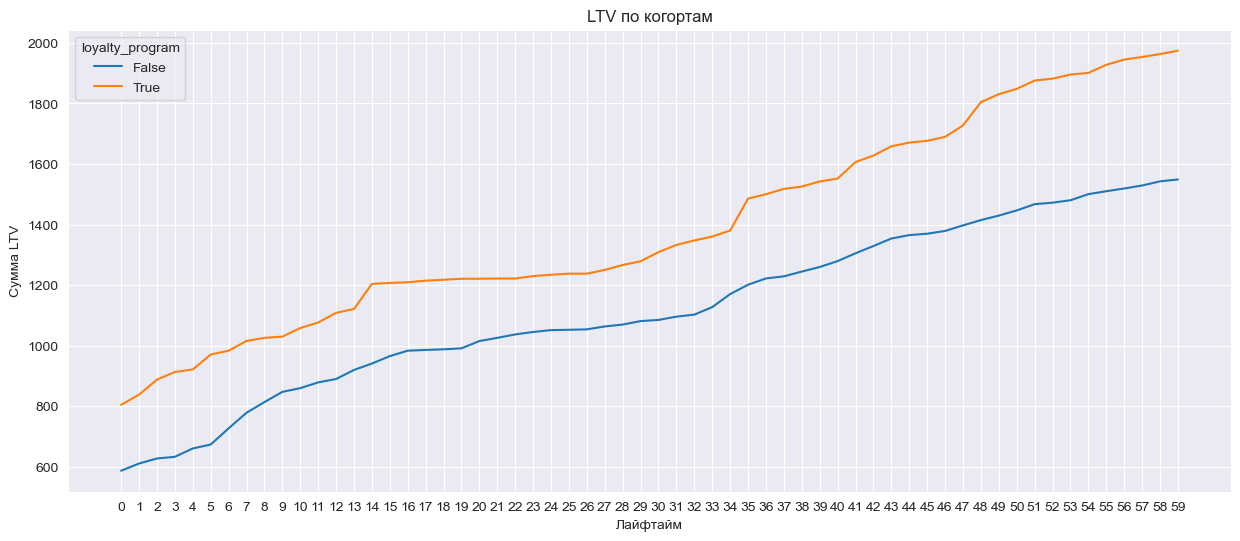

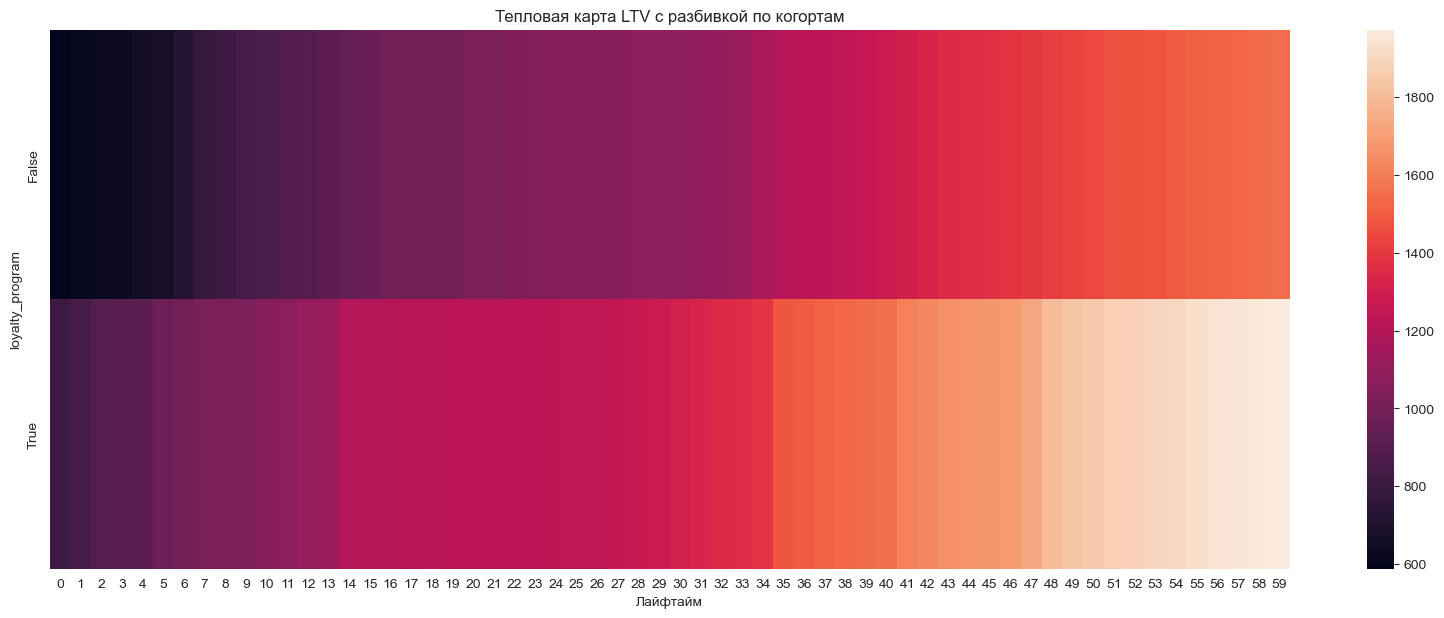

In [55]:
observation_date = datetime(2017, 2, 28).date()
horizon_days = 60
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, purchase_sum[[
        'customer_id', 'purchase_date', 'sum']], observation_date, horizon_days, dimensions=['loyalty_program']
)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(15, 6), xticks=list(report.columns.values), ax=plt.subplot(1, 1, 1))
plt.title('LTV по когортам')
plt.ylabel('Сумма LTV')
plt.xlabel('Лайфтайм')

fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(report, ax=plt.subplot(1, 1, 1))
plt.title('Тепловая карта LTV с разбивкой по когортам')
plt.xlabel('Лайфтайм')
plt.show()

Представленные график и тепловая диаграмма показывают, что наибольшее количество денег в итоге приносят покупатели, участвующие в программе лояльности, учитывая при этом тот факт, что таких клиентов меньше. Если смотреть на динамику LTV при горизонте 60 дней, то мы видим, что рост наблюдается в обеих когортах, однако его динамика в группе покупателей из программы лояльности более имеет более интенсивный рост. Повышение уровня LTV довольно плавное, наблюдаются небольшой скачок у "лояльных" покупателей в первой декаде, в середине месяца и в третьей декаде периода 60 дней, что может быть связано с возможными проводимыми акциями. У обычных покупателей подобных скачков не наблюдается. Тепловая диаграмма также подтверждает такие выводы.

<b>Изучение представленных данных показало, что среди всего количества покупателей только 23412 клиентов принимают участие в программе лояльности, что составляет 27% от общего количества. Среди покупок есть чеки с отрицательной суммой. Возможными причинами являются ошибочные покупки, возврат товара, а также ошибки при формировании таблицы. Также мы выяснили, что в данных есть довольно серьезные выбросы, менее одного процента строк с суммой покупки более 354,34руб. После очистки данных от выбросов и отрицательных значений мы провели анализ покупок с разбивкой по когортам: покупатели, участвующие в программе лояльности, и остальные покупатели. В результате анализа мы выяснили, что в среднем покупатели из первой когорты (участники программы лояльности) приобретают немного больше товаров, но при этом средний чек у них ниже, что можно объяснить предложением большего количества акционного товара по сниженным ценам по программе лояльности. Расчет общего количества денег, приносимых покупателями дал понять, что положительная динамика показателя LTV наблюдается в обеих когортах, но у покупателей-участников программы она проявляется гораздо лучше, чем у обычных покупателей.<b>

 ### Проверка статистических гипотез</div>

В финале исследования проверим гипотезы о том, что средний чек участников программы лояльности выше, чем у остальных покупателей и о то, что среднее количество товара в корзине покупателей, участвующих в программе, больше, чем у остальных. Для проверки используем метод Манна-Уитни, так как данный способ позволяет получить более корректный вывод при наличии большой выборки и значительных выбросов. Для этого используем таблицу без удаленных аномальных значений.

In [56]:
x=purchase_sum[purchase_sum['loyalty_program'] == True]['sum']
y=purchase_sum[purchase_sum['loyalty_program'] == False]['sum']
x.name, y.name = 'True', 'False'

In [57]:
alpha = 0.05 # ваш код

results = results = st.mannwhitneyu(x, y, True, 'less')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-значение:  1.0
Не получилось отвергнуть нулевую гипотезу


Первая гипотеза о том, что средний чек участников программы выше, чем у остальных покупателей, отвергается, что подтверждает наши предыдущие расчеты и выводы.

Далее проверим гипотезу о том, что среднее количество товара в чеке у участников программы больше, чем у обычных покупателей.

In [58]:
x=purchase_sum[purchase_sum['loyalty_program'] == True]['quantity']
y=purchase_sum[purchase_sum['loyalty_program'] == False]['quantity']
x.name, y.name = 'True', 'False'

In [59]:
alpha = 0.05 # ваш код

results = results = st.mannwhitneyu(x, y, True, 'greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-значение:  0.9995756486150835
Не получилось отвергнуть нулевую гипотезу


Результат теста показывает, что первая гипотеза о преобладании количества товара в чеке участников программы подтверждается.

 ### Подведение итогов исследования и формулировка рекомендаций для отдела маркетинга</div>

В результате проведенного исследования представленных данных о продажах магазина строительных материалов «Строили, строили и наконец построили» мы провели предобработку этих данных:
  - привели названия колонок в таблицах к единообразию;
  - преобразовали данные в некоторых столбцах и удалили дубликаты;
  - выяснили, что представлены данные о покупательской активности за период с 01 декабря 2016 года по 28 февраля 2017 года;
  - после удаления дублирующихся значений в таблице data имеется 104302 строки с данными об id покупателей, магазинов, стоимости и количестве купленного товара товара, дате покупок и участии или неучастии покупателя в программе лояльности.

В итоге исследовательского анализа данных выяснили следующие моменты:
  - среди всего количества покупателей только 23412 клиентов принимают участие в программе лояльности, что составляет 27% от        общего количества;
  - в датасете есть строки с отрицательной суммой. Возможными причинами являются ошибочные покупки, возврат товара, а также        ошибки при формировании таблицы;
  - в данных есть аномальные выбросы, менее одного процента строк с суммой покупки более 354,34руб. 
    
После очистки данных от выбросов и отрицательных значений мы провели анализ покупок с разбивкой по когортам: покупатели, участвующие в программе лояльности, и остальные покупатели. В результате анализа мы выяснили следующее:
  - в среднем покупатели из первой когорты приобретают немного больше товаров, но при этом средний чек у них ниже, что можно        объяснить предложением большего количества акционного товара по сниженным ценам по программе лояльности;
  - в программе участвуют только 4 магазина: Shop 0, Shop 8, Shop 19, Shop 28. Причем в первых двух покупки совершают и        участники программы и обычные покупатели, в shop 28 только участники. Возможно данную программу решили протестировать только в нескольких магазинах для получения аналитических данных об экономической целесообразности её внедрения во все магазины. Поэтому вероятно наш дальнейший анализ надо провести, ориентируясь на эти магазины, а также добавить в этот список Shop 15, так как там показатели "продажи количества единиц товара" и "общая сумма продажи" примерно схожи с Shop 28;
  - покупатели из разных когорт любят закупаться по пятницам, в остальные дни показатели размера покупок отличаются у двух групп. У обычных покупателей популярные дни после пятницы вторник, среда, четверг и суббота. В понедельник обычные посетители магазина делают самые маленькие по размеру покупки. У участников программы наблюдается немного другая картина. После пятницы следующий день четверг, затем вторник, среда, понедельник и суббота. По какой-то причине в данных отсутствует информация о продажах по воскресеньям. Возможно в воскресенье в сети магазинов выходной день;
  - наибольшее количество товара покупателями обеих групп покупалось в декабре, затем в когорте обычных покупателей идет январь и в феврале наблюдался спад активности. Если смотреть на участников программы лояльности, то после активного декабря в январе было снижение покупательской активности, которая немного подросла в феврале.
  - расчет общего количества денег, приносимых покупателями дал понять, что положительная динамика показателя LTV            наблюдается в обеих когортах, но у обычных покупателей она проявляется гораздо лучше, чем у покупателей-участников программы.
    
В результате проверки гипотез о среднем чеке и среднем количестве товара было подтверждено предположение о том, что средний чек участников программы не выше, чем у остальных покупателей, а среднее количество товара в корзине покупателей, участвующих в программе, больше, чем у остальных    
       
Исходя из полученных данных можно предположить, что программа лояльности проводится достаточно успешно, мы не наблюдаем роста в среднем чеке, но в количестве товара на покупателя есть преимущество перед обычными покупателями и этого достаточно, чтобы позволить получить достаточную прибыль.
    
Возможные рекомендации:
  - распространение программы лояльности на другие магазины сети;
  - проведение мониторингового исследования на предмет определения наиболее привлекательного для покупателей товара.